# Intro

Name:  

    Build_surface_albedo_seac4rs

Purpose:  

    Python script that builds surface albedo from SSFR measurements
    saves in a format that is useful for libradtran inputs

Calling Sequence:

    python Build_surface_albedo_seac4rs.py
  
Input:

    none at command line
  
Output:

    figures and text files
  
Keywords:

    none
  
Dependencies:

    - matplotlib
    - mpltools
    - numpy
    - scipy : for saving and reading
    - os
    - pdb : for debugging
    - datetime
    - mpl_toolkits
    - plotting_utils (user defined plotting routines)
  
Needed Files:

  - SSFR calibspcs .out file

# Imports and data file paths

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpltools import color

In [18]:
%matplotlib notebook
import numpy as np, h5py
import scipy.io as sio
import scipy
import Sp_parameters as Sp

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:

# set the basic directory path
fp='C:/Users/sleblan2/Research/SEAC4RS/'

# Load SSFR file

In [4]:
daystr = '20130913'

In [5]:
ssfr = sio.idl.readsav(fp+'dc8/dc8_'+daystr+'_calibspcs_attcorr_v2.out')

<IPython.core.display.Javascript object>


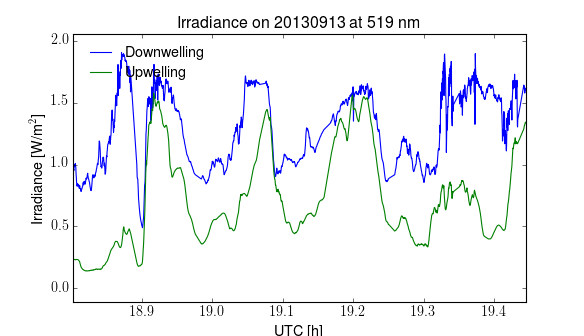

In [34]:
plt.figure()
plt.plot(ssfr.tmhrs,ssfr.zspectra[:,50],label='Downwelling')
plt.plot(ssfr.tmhrs,ssfr.nspectra[:,50],label='Upwelling')
plt.ylabel('Irradiance [W/m$^{2}$]')
plt.xlabel('UTC [h]')
plt.title('Irradiance on '+daystr+' at %4i nm' % ssfr.zenlambda[50])
plt.legend(frameon=False,loc=2)

## Loop and interpolate nadir spectra to zenith wavelengths

In [7]:
from scipy.interpolate import interp1d
fn = interp1d(ssfr.nadlambda,ssfr.nspectra,axis=1,bounds_error=False)
ssfr.nnspectra = fn(ssfr.zenlambda)

In [8]:
wvl = np.arange(350,1701)

In [9]:
ssfr.nspectra1 = fn(wvl)

In [10]:
fz = interp1d(ssfr.zenlambda,ssfr.zspectra,axis=1,bounds_error=False)
ssfr.zspectra1 = fz(wvl)

## Find the correct times for plotting and outputting

In [11]:
import Sp_parameters as Sp

In [42]:
tice = 19.12
twat = 19.27

In [43]:
iice = np.argmin(abs(ssfr.tmhrs-tice))
iwat = np.argmin(abs(ssfr.tmhrs-twat))

In [36]:
alb = ssfr.nspectra1/ssfr.zspectra1
alb[alb<=0.0] = 0.0
alb[alb>=1.0] = 1.0
alb[np.isnan(alb)] = 0.0

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


<IPython.core.display.Javascript object>


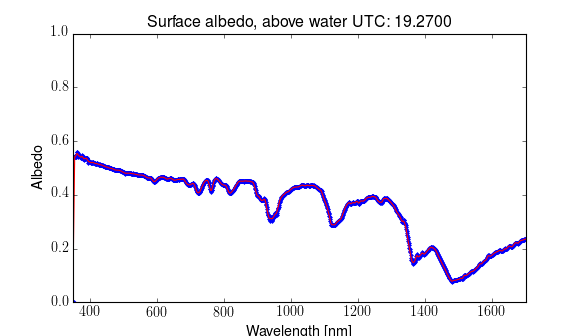

In [37]:
plt.figure()
plt.plot(wvl,alb[iwat,:],'b.')
plt.plot(wvl,Sp.smooth(alb[iwat,:],6),'r')

plt.xlim([350,1700])
plt.ylim([0,1])
plt.ylabel('Albedo')
plt.xlabel('Wavelength [nm]')
plt.title('Surface albedo, above water UTC: %.4f' % ssfr.tmhrs[iwat])
plt.savefig(fp+'dc8/'+daystr+'_surface_albedo_ice.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


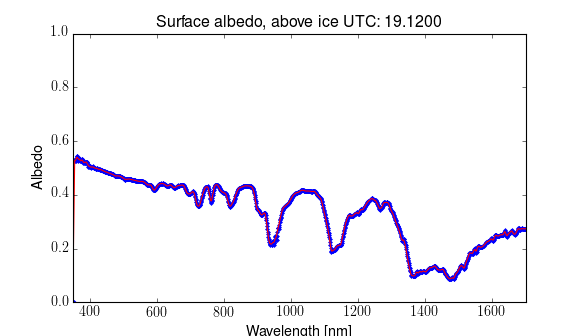

In [38]:
plt.figure()
plt.plot(wvl,alb[iice,:],'b.')
plt.plot(wvl,Sp.smooth(alb[iice,:],6),'r')
plt.xlim([350,1700])
plt.ylim([0,1])
plt.ylabel('Albedo')
plt.xlabel('Wavelength [nm]')
plt.title('Surface albedo, above ice UTC: %.4f' % ssfr.tmhrs[iice])
plt.savefig(fp+'dc8/'+daystr+'_surface_albedo_ice.png',dpi=600,transparent=True)

In [39]:
alb_wat = Sp.smooth(alb[iwat,:],6)
alb_ice = Sp.smooth(alb[iice,:],6)

## Plot the two sections on top of each other

<IPython.core.display.Javascript object>


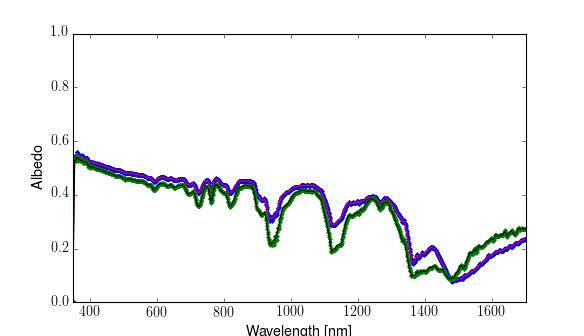

In [44]:
plt.figure()
plt.plot(wvl,alb[iwat,:],'b.',label='{:.2f} UTC'.format(twat))
plt.plot(wvl,Sp.smooth(alb[iwat,:],6),'r')

plt.plot(wvl,alb[iice,:],'g.',label='{:.2f} UTC'.format(tice))
plt.plot(wvl,Sp.smooth(alb[iice,:],6),'k')

plt.xlim([350,1700])
plt.ylim([0,1])
plt.ylabel('Albedo')
plt.xlabel('Wavelength [nm]')

# Save to file

In [47]:
f = open(fp+daystr+'_surf_alb_v5.dat','w')
for i in xrange(len(wvl)):
    f.write('%i %.4f \n' % (wvl[i],alb_wat[i]))
f.close()

In [46]:
f = open(fp+daystr+'_surf_alb_ice.dat','w')
for i in xrange(len(wvl)):
    f.write('%i %.4f \n' % (wvl[i],alb_ice[i]))
f.close()